# Ensemble Learning: Programming Practice

COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

## Overview

This notebook will give you some practice training ensemble learning algorithms, including
  1. Random Forests
  2. AdaBoost
  3. Gradient Boostin
  4. Bagging & Voting Classifiers
  
We will be using the heart failure dataset from previous classes as well as a new dataset of student school performance.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import sklearn.tree
import sklearn.neighbors
import sklearn.linear_model
import sklearn.svm
import sklearn.datasets

## Part 1. Random Forests

We will be using the "Student Performance Data Set" from the UC Irving Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Student+Performance). The dataset is from a school in Portugal and includes 30 student demographic features along with student performance in a math class. This dataset is not standardized and has many categorical features that require encoding. Our goal will be to see whether we can train a random forest to predict math performance from student demographic data alone. 

The `load_process_student_data()` function performs all necessary data import and preprocessing steps.

In [4]:
def load_process_student_data():
    X = pd.read_csv("student-mat.csv", delimiter=";")

    # Separate labels
    y = X['G3']

    # Drop labels
    X.drop(["G1", "G2", "G3"], axis=1, inplace=True)

    # List of the column names with features that should be ordinal encoded
    ordinal_features = ['school', 'sex', 'address', 'famsize', 'Pstatus',
                       'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                       'higher', 'internet', 'romantic']

    # Ordinal encode all of these features
    ordinal = sklearn.preprocessing.OrdinalEncoder()
    X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])

    # List of the column names with nominal features that should be one-hot encoded
    onehot_features = ['Mjob', 'Fjob', 'reason', 'guardian']

    # One-hot encode these features 
    X = pd.get_dummies(X, columns=onehot_features)
    
    # Return preprocessed data
    return X, y

In [5]:
# Load and preprocess student data (code from prior class notebooks in import_student_data.py)
X_train, y_train = load_process_student_data()
print(X_train.shape)
print(y_train.shape)

(395, 43)
(395,)


In [ ]:
# Print shapes of data and labels


When training a random forest, the most important hyperparameter is the number of trees in the forest. Let's use the `GridSearchCV` function to try a range of forest sizes

In [8]:
# Cross-validation folds
k = 10

# Hyperparameters to tune:
params = {"n_estimators": range(1, 100, 3)}

# Initialize GridSearchCV object with decision tree classifier and hyperparameters
grid_forest = sklearn.model_selection.GridSearchCV(estimator=sklearn.ensemble.RandomForestRegressor(random_state=0), param_grid = params, cv = k, return_train_score=True, scoring='neg_mean_absolute_error', refit=True)

# Train and cross-validate, print results
grid_forest.fit(X_train, y_train)
grid_forest_result = pd.DataFrame(grid_forest.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
grid_forest_result[['param_n_estimators', 'mean_test_score']]

,param_n_estimators,mean_test_score
15,46,-3.074947
16,49,-3.076689
14,43,-3.082871
19,58,-3.087666
18,55,-3.087726
17,52,-3.089058
27,82,-3.100486
26,79,-3.100737
20,61,-3.101006
21,64,-3.101460


We can use the optimized random forest model to find the feature importances

In [9]:
# Train Random Forest with the optimal number of trees and get feature importances (your optimal n_estimators may vary)
rf = grid_forest.best_estimator_
pd.Series(rf.feature_importances_, X_train.columns).sort_values(ascending=False)


absences             0.185325
failures             0.145157
goout                0.045261
health               0.039495
freetime             0.039190
Walc                 0.034127
studytime            0.033195
Medu                 0.032363
age                  0.031849
traveltime           0.029736
Fedu                 0.026479
sex                  0.024826
schoolsup            0.024793
famrel               0.022939
Mjob_services        0.021461
activities           0.014466
guardian_other       0.014131
famsup               0.013297
romantic             0.013052
Mjob_at_home         0.011902
higher               0.011883
Dalc                 0.011217
Fjob_teacher         0.010898
reason_home          0.010822
Mjob_other           0.010682
address              0.010265
Fjob_other           0.009935
reason_course        0.009909
Fjob_at_home         0.009860
famsize              0.009592
school               0.009571
Mjob_health          0.009417
paid                 0.008556
internet  

**DISCUSSION:** What do these feature importances tell you about the phenomenon we are modeling? How does the ranking of the features by importance align with your expectations about student performance?

## Part 2. Boosting

In Lab 2, we attempted to predict heart failure deaths of cardiac patients. We will return to this dataset to see whether a gradient boosting approach will improve classifier accuracy. 

In [10]:
# load dataset
X_train = pd.read_csv("heart_failure_clinical_records_dataset.csv")
y_train = X_train["DEATH_EVENT"]
X_train.drop("DEATH_EVENT", axis=1, inplace=True)

In [13]:
# Try gradient boosting for a range of boosting rounds to see how many rounds are needed to stabilize performance
n_rounds = range(1, 100, 3)
val_scores = []
train_scores = []

# Loop over number of boosting rounds
for rounds in n_rounds:
    
    # Create classifier
    gb = sklearn.ensemble.GradientBoostingClassifier(n_estimators=rounds)
    
    # Cross-validation scores
    scores = sklearn.model_selection.cross_validate(gb, X_train, y_train, scoring='f1', cv=10, return_train_score=True)
    val_scores.append(scores['test_score'].mean())
    train_scores.append(scores['train_score'].mean())

# Print best score
print("Max val score: ", max(val_scores))

Max val score:  0.5511627588098176


<AxesSubplot:>

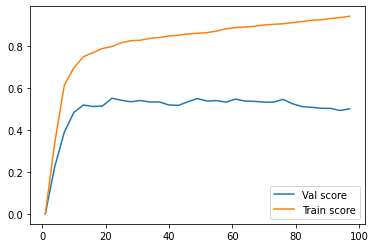

In [14]:
# Plot F1 score versus number of boosting rounds
sns.lineplot(x=n_rounds, y=val_scores, label="Val score")
sns.lineplot(x=n_rounds, y=train_scores, label="Train score")

We could do the same problem with AdaBoost just by replacing the `GradientBoostingClassifier` with `AdaBoostClassifier`

In [ ]:
# Load dataset and preprocess
digits = sklearn.datasets.load_digits()
X = digits.images
y = digits.target
X = digits.images.reshape((len(digits.images), -1))
X_train = sklearn.preprocessing.StandardScaler().fit_transform(X_train)

In [ ]:
X_train

In [ ]:
# Train a single SVM with a polynomial kernel
svm = sklearn.svm.SVC(kernel='poly', C=10, decision_function_shape="ovr")
scores = sklearn.model_selection.cross_val_score(svm, X_train, y_train, cv=10)
print("Single SVM accuracy:", scores.mean())

In [ ]:
# Train an ensemble of 100 SVMs using bagging
svm = sklearn.svm.SVC(kernel='poly', C=100)
bag = sklearn.ensemble.BaggingClassifier(base_estimator=svm, n_estimators=100)
scores = sklearn.model_selection.cross_val_score(bag, X_train, y_train, cv=10)
print("100-Bagging SVM accuracy:", scores.mean())

In [ ]:
# Train a 4 different types of models and use soft voting to choose final classification
estimators = [('svm', sklearn.svm.SVC(kernel='poly', C=100, probability=True)), 
              ('dt', sklearn.tree.DecisionTreeClassifier()),
              ('lr', sklearn.linear_model.LogisticRegression()),
              ('knn', sklearn.neighbors.KNeighborsClassifier())]

vc = sklearn.ensemble.VotingClassifier(estimators=estimators, voting='soft')
    
scores = sklearn.model_selection.cross_val_score(vc, X_train, y_train, cv=10)

print('Voting Classifiers accuracy:', np.mean(val_scores))